In [1]:
using RDatasets
using Base.Iterators
a = dataset("datasets", "anscombe")

,X1,X2,X3,X4,Y1,Y2,Y3,Y4
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,10,10,10,8,8.04,9.14,7.46,6.58
2,8,8,8,8,6.95,8.14,6.77,5.76
3,13,13,13,8,7.58,8.74,12.74,7.71
4,9,9,9,8,8.81,8.77,7.11,8.84
5,11,11,11,8,8.33,9.26,7.81,8.47
6,14,14,14,8,9.96,8.1,8.84,7.04
7,6,6,6,8,7.24,6.13,6.08,5.25
8,4,4,4,19,4.26,3.1,5.39,12.5
9,12,12,12,8,10.84,9.13,8.15,5.56


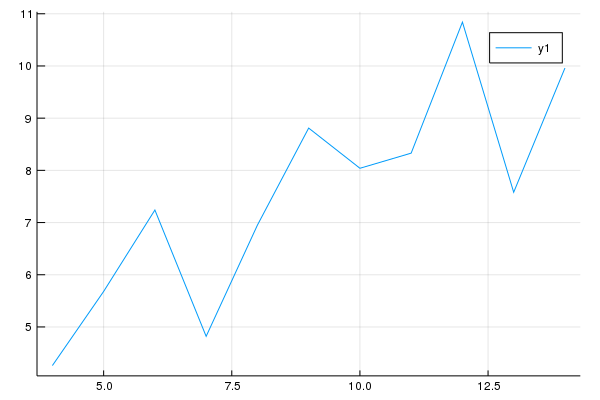

In [3]:
using Plots
sort!(a, [:X1])
plot(a[:X1], a[:Y1])

In [9]:
using Statistics
import Distributions: Normal
mean.(getindex.(Ref(a), [:X1,:Y1])), std.(getindex.(Ref(a), [:X1,:Y1])), cor(Matrix(a[[:X1, :Y1]]))[1,2]

([9.0, 7.50091], [3.31662, 2.03157], 0.81642051634484)

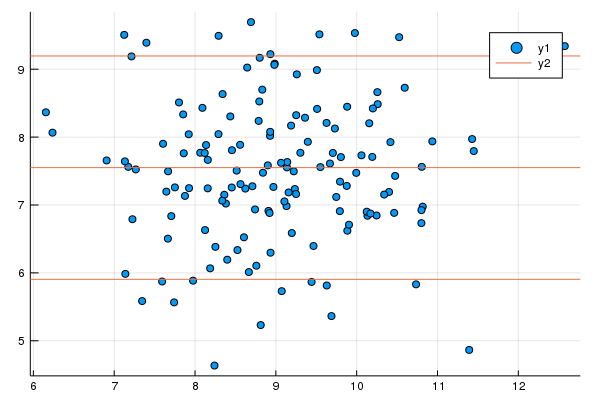

In [11]:
using Flux
using Flux.Tracker: forwarddiff
#randx = param(rand(size(a,1)) .* std(a[:X1]) .+ mean(a[:X1]))
#randy = param(rand(size(a,1)) .* std(a[:Y1]) .+ mean(a[:Y1]))
#randx, randy, a[:X1], a[:Y1]

mm= extrema(a[:Y1])
t1 = (mm[2]-mm[1])/4+ mm[1]
t2 = (mm[2]-mm[1])/4*2 + mm[1]
t3 = (mm[2]-mm[1])/4*3 + mm[1]
t1,t2

meanx = mean(a[:X1])
meany = mean(a[:Y1])
meanx, meany, t1, t2

stdx = std(a[:X1])
stdy = std(a[:Y1])

prex = rand(Normal(0,1), 141)
prey = rand(Normal(0,1), 141)

randx = param(prex .- mean(prex) .+ meanx)
randy = param(prey .- mean(prey) .+ meany)
randx, randy

plot(Tracker.data(randx), Tracker.data(randy), seriestype=:scatter)
hline!([t1, t2, t3])

In [15]:
targety = repeat([t1,t2,t3], inner = 47)
targetx = repeat(range(4, length = 47,stop = 14), outer = 3)

#targetx = repeat(range(4, stop = 14, length = 51), outer = 2)
#targety = vcat(range(4, stop = 14, length = 51), range(14, stop = 4, length = 51))

141-element Array{Float64,1}:
  4.0               
  4.217391304347826 
  4.434782608695652 
  4.6521739130434785
  4.869565217391305 
  5.086956521739131 
  5.304347826086956 
  5.521739130434782 
  5.739130434782608 
  5.956521739130435 
  6.173913043478261 
  6.391304347826087 
  6.608695652173913 
  ⋮                 
 11.608695652173912 
 11.826086956521738 
 12.043478260869565 
 12.26086956521739  
 12.478260869565217 
 12.695652173913043 
 12.91304347826087  
 13.130434782608695 
 13.347826086956522 
 13.565217391304348 
 13.782608695652174 
 14.0               

In [16]:
loss_formation1() = begin        
    miny = mean((randx .- targetx).^2) + mean((randy .- targety).^2)   
    
    #miny = log(1 + miny) * (1+mean((randx .- meanx).^2)+mean((randy .- meany).^2))
    
    return miny
end

loss_formation2() = begin        
    miny = mean((randx .- targetx).^2) + mean((randy .- targety).^2)
        
    miny = log(1 + miny) + 10*(mean((randx .- meanx).^2)+mean((randy .- meany).^2))
   
    return miny
end

gs = Tracker.gradient(() -> loss_formation1(), params(randx, randy))
gs2 = Tracker.gradient(() -> loss_formation2(), params(randx, randy))
opt = ADAM()
loss_formation1()

12.817182222374207 (tracked)

In [17]:
using Flux.Tracker: update!

function ok(loss, gs) 
    last_loss = float(9999)
    i = 0
    while true
        i += 1
        delta1 = gs[randx]
        delta2 = gs[randy]        
        update!(randx, -0.01delta1), update!(randy, -0.01delta2)

        new_loss = loss()
        if new_loss < last_loss
            last_loss = new_loss
        else
            println(i)
            println(loss())
            return mean(Tracker.data(randx)), mean(Tracker.data(randy))
        end
    end
end

ok (generic function with 1 method)

In [150]:
ok(loss_formation1, gs)

5101
2.5714170349617943e-6 (tracked)


(9.00075064457438, 9.000811528780243)

In [151]:
ok(loss_formation2, gs2)
#ok(lossx, gsx, true)

2
196.23603668314192 (tracked)


(9.015785652043311, 9.011187226297466)

In [152]:
tx = Tracker.data(randx)
ty = Tracker.data(randy)
#round.((mean(tx), meanx, mean(ty), meany, std(tx), stdx, std(ty), stdy), digits=2)
round.((mean(tx), meanx, mean(ty), meany), digits=2)

(9.02, 9.0, 9.01, 7.5)

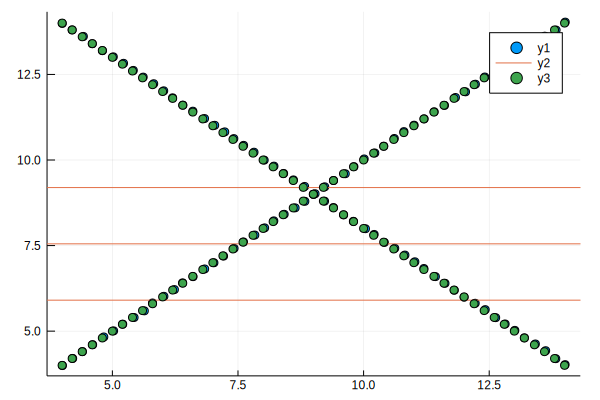

In [153]:
pred = DataFrame(x = Tracker.data(randx), y = Tracker.data(randy))

p = plot(pred[:x], pred[:y], seriestype=:scatter)
hline!([t1, t2, t3])
plot!(targetx, targety, seriestype=:scatter)